<a href="https://colab.research.google.com/github/sraeisi/Machine_Learning_Physics_Winter20/blob/master/Chpt3/Model_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pre
====

In [0]:
# %load https://raw.githubusercontent.com/sraeisi/MachineLearning_Physics/master/pre.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from google.colab import files
import io, requests, zipfile



'''Set the defaults for your plots.'''
# plt.rcParams.update({'font.size': 20, 'figsize':(8,6)})
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('axes', linewidth = 5 )
plt.rc('lines', linewidth = 5 )

plt.rc('lines', markersize = 5 )

plt.rc('figure', figsize=(8,4) )         # Image size

from zipfile import ZipFile


from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle

# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
# from sklearn.svm import SVR
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import PolynomialFeatures , StandardScaler, RobustScaler
# from sklearn.metrics import mean_squared_error  ## To calculate the loss
# from sklearn.naive_bayes import GaussianNB
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import learning_curve, validation_curve

In [0]:
def grid(x1, x2, off_set = .1, n_points = 100):
    ## d s show the range in the two varible. 
    d1 = x1.max() - x1.min()
    d2 = x2.max() - x2.min()
    
    x1_min, x1_max = x1.min() - off_set * d1 , x1.max() + off_set * d1
    x2_min, x2_max = x2.min() - off_set * d2 , x2.max() + off_set * d2

    ## This function from numpy gives a list of coordinates that are the points on the grid. 
    x, y = np.meshgrid(np.arange(x1_min, x1_max , d1/n_points), np.arange(x2_min, x2_max , d2/n_points) )

    return x , y

# Classification Metrics

For this section we are going to again use the particle identification data from 


https://www.kaggle.com/naharrison/particle-identification-from-detector-responses/home

We start with the binary classification and then get to the multi class case. 

## Binary Classification

### Example

In [0]:
## First load the data from the following url
url = 'https://www.dropbox.com/s/66dbhxl93y41coe/particle-identification-from-detector-responses.zip?dl=1'
s=requests.get(url, stream=True).content
data=pd.read_csv(io.BytesIO(s) , compression='zip' )

data = shuffle(data)

'''
Alternatively, you can download the file into your computer and run the following code. 
You need to uncomment it first. 
'''    

# data = pd.read_csv('particle-identification-from-detector-responses.zip', compression='zip')
data.head()

,id,p,theta,beta,nphe,ein,eout
3595956,211,2.634170,0.229833,1.008830,0,0.000000,0.042527
2583637,2212,1.193410,0.414309,0.805524,0,0.089723,0.174685
4109833,211,0.707713,0.316321,0.985953,0,0.083589,0.000000
4282633,2212,0.906538,0.327753,0.690128,0,0.071687,0.067750
2758800,2212,1.566950,0.344759,0.855016,0,0.143420,0.207965


In [0]:
## Targets
targets = list(set(data['id']))
print(targets)
target_freq = Counter(data['id'])


features =  data.columns 
print(features)


[321, 211, 2212, -11]
Index(['id', 'p', 'theta', 'beta', 'nphe', 'ein', 'eout'], dtype='object')


In [0]:
## We only keep two features, this is for simplicity and also for visulaization purposes. 
features_2d = features[[0,1,3]]


## To speed things up in the class we take a small sample of the data

n_s = 10000  ## number of samples we keep. 

mini_data = data[features_2d].sample(n_s, axis=0, random_state=0)

mini_data['target'] = mini_data['id'].apply(lambda x: targets.index(x)) ## We add a label/target/class col which is the index of the id in the list of ids.

mini_data.drop('id',axis=1, inplace=True)
mini_data.head()


,p,beta,target
1892568,0.212253,0.830649,1
587313,0.504158,0.964165,1
125060,1.346150,0.829017,2
2908640,2.610670,0.984403,0
4397666,1.433590,0.842036,2


##Binary Classification

In [0]:
print('The classes and corresponding frequencies are: \n {}'.format(dict(Counter(data['id'])) )) 

The classes and corresponding frequencies are: 
 {211: 2806833, 2212: 1945849, -11: 14847, 321: 232471}


In [44]:
## We only keep the following two targets
## We intentionally pick two classes with the largest bias. 
ind_1 = 0
ind_2 =  1
print('The ratio of the number of the samples of the two classes are {}'.format( target_freq[targets[ind_1]]/target_freq[targets[ind_2]] ) )


## Only keep the part of the data with one of the two target classes. 
bmd = mini_data[ (mini_data['target']==ind_1) | (mini_data['target']==ind_2) ].copy()


X = bmd.drop('target', axis=1).values
Y = bmd['target'].values


The ratio of the number of the samples of the two classes are 0.08282323886030982


In [45]:
# Now, let's start keeping a subset of the data separate for evaluation.
# We can do this manually or use a built-in function from sklearn. 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
                                          X  , Y, 
                                          random_state = 0 , 
                                          test_size = .2
                                          )

print('Our train set has: {}'.format( dict( Counter(Y_train) ) ))
print('Our test set has: {}'.format(  dict( Counter(Y_test) ) ))
print('And in total, the whole set has: {}'.format(  dict( Counter( Y ) ) ))

Our train set has: {1: 4498, 0: 358}
Our test set has: {1: 1136, 0: 79}
And in total, the whole set has: {1: 5634, 0: 437}


In [22]:
## Let's try a dummy classifier that constantly outputs the more frequent class.
from sklearn.dummy import DummyClassifier

dm_clf = DummyClassifier(strategy='most_frequent')
dm_clf.fit(X_train, Y_train)
print('A dummy classifier can achieve a accuracy as high as {} on the test data.'.format(dm_clf.score(X_test,Y_test)))

A dummy classifier can achieve a accuracy as high as 0.9349794238683128 on the test data.


This indicates that even an ignorant classifier can achieve a high score for this task, where it is totally ignoring one of the classes. 

How should we deal with this?

We need to ask what we really care about? Is the accuracy the right metric for this problem?

Alternatives

**Precision**: The fraction of prediction that we got right. 

**Recall**: The fraction of the instances that were predicted correctly. 

Note that this can be defined for each class and they are not necessarily the same. 

For this we need to go back to basic statistics and see what could happen in a classification problem like this. Here's a famous picture that you probably have seen before:


| **True Positive(TP)** || **False Positive(FP)**   |
|------||------|
|   **False Negative(FN)**   || **True Negative(TN)**|


Here follow the same ideas and use different metrics for evalution of our models.


In [34]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
print(f"Here is the confusion matrix for the dummy classifier: \n {confusion_matrix(Y, dm_clf.predict(X))}"  )

Here is the confusion matrix for the dummy classifier: 
 [[   0  437]
 [   0 5634]]


In [31]:
from sklearn.metrics import recall_score, precision_score
print(f"The recall for the dummy classifier: \n {recall_score(Y, dm_clf.predict(X))}"  )
print(f"The precision for the dummy classifier: \n {precision_score(Y, dm_clf.predict(X))}"  )

The recall for the dummy classifier: 
 1.0
The precision for the dummy classifier: 
 0.9280184483610607


In [85]:
%%time
from sklearn.svm import SVC
# from sklearn.model_selection import cross_val_score, cross_validate
g = 1
c = 1
clf = SVC(gamma = g , C = c)
clf.fit(X_train, Y_train)

print(f"The accuracy of the SVM CLF is {clf.score(X_test, Y_test )}.")
print(f"The recall of the SVM CLF is  \n {recall_score(Y_test, clf.predict(X_test), pos_label=0)}"  )
print(f"The precision of the SVM CLF is  \n {precision_score(Y_test, clf.predict(X_test), pos_label=0)}"  )

The accuracy of the SVM CLF is 0.9415637860082304.
The recall of the SVM CLF is  
 0.189873417721519
The precision of the SVM CLF is  
 0.6818181818181818
CPU times: user 262 ms, sys: 1.87 ms, total: 264 ms
Wall time: 267 ms


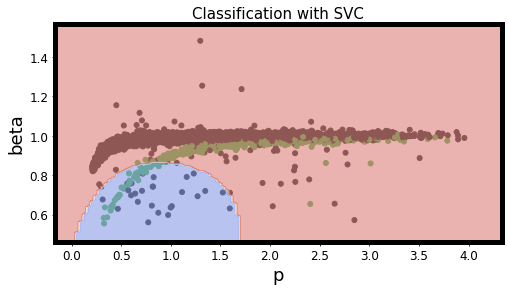

In [86]:
x_label = features_2d[1]
y_label = features_2d[2]

clf = SVC( gamma = g, C = c )
clf.fit(X_train, Y_train)

x1_list, x2_list = grid(X[:,0], X[:,1], n_points=100)
X_grid = np.vstack([x1_list.reshape(-1),x2_list.reshape(-1)]).T
Y_grid = clf.predict( X_grid ).reshape(x1_list.shape )

plt_title = 'Classification with SVC'
fig = plt.figure()
ax = fig.add_subplot(111,xlabel=x_label, ylabel = y_label, title = plt_title)
ax.scatter(*X_train.T, c=Y_train, cmap=plt.cm.Accent)
ax.contourf(x1_list, x2_list, Y_grid, alpha=.4, cmap=plt.cm.coolwarm)

plt.show()

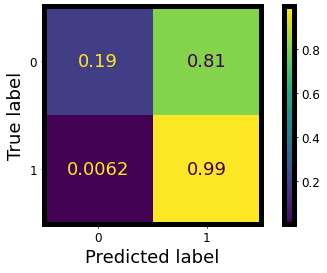

In [87]:
plot_confusion_matrix(clf, X_test, Y_test, normalize='true')

In [92]:
## Metric for findig the right model
## The right metric/loss depends on the specifics of the question and what our objective is. 
## One common solution is to take a combination of the precision and recall, called f_score
## Which is defined as a (1+beta)(precision*recall)/(beta*precision+recall).
## For beta=1, we get the famous f1 score. For beta = 0  and inf what does it go to?
## We often use the report in sklearn to get all of these values. 

from sklearn.metrics import classification_report
clf_report = classification_report(Y_test, clf.predict(X_test))
print(clf_report)

              precision    recall  f1-score   support

           0       0.68      0.19      0.30        79
           1       0.95      0.99      0.97      1136

    accuracy                           0.94      1215
   macro avg       0.81      0.59      0.63      1215
weighted avg       0.93      0.94      0.93      1215



### Playing with threshold to change the precision or recall. 

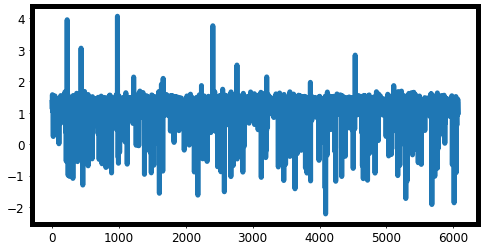

In [89]:
f_y = clf.decision_function(X)
plt.plot(f_y)
# plt.plot(predicted_Y)
plt.show()

In [90]:
'''
The following function defines and returns a new classifier based on the clf. 
It is assuming that the clf has a decision function. 
The output is a clf that instead of 0, the threshold for returning a class is 
set by thrshld. 
'''
def clf_with_thrshld(clf,thrshld=0):
  try:
    def new_clf(X):
      return (clf.decision_function(X)> thrshld)
    
    return new_clf
  except e:
    print("This clf has no decision function.")



## test it: with default thrshold = 0, they should be the same. 
clf_with_thrshld(clf)(X)-clf.predict(X)

array([0, 0, 0, ..., 0, 0, 0])

The confusion matrix is: 
 [[  74  363]
 [  33 5601]]

The classification report is: 
               precision    recall  f1-score   support

           0       0.69      0.17      0.27       437
           1       0.94      0.99      0.97      5634

    accuracy                           0.93      6071
   macro avg       0.82      0.58      0.62      6071
weighted avg       0.92      0.93      0.92      6071




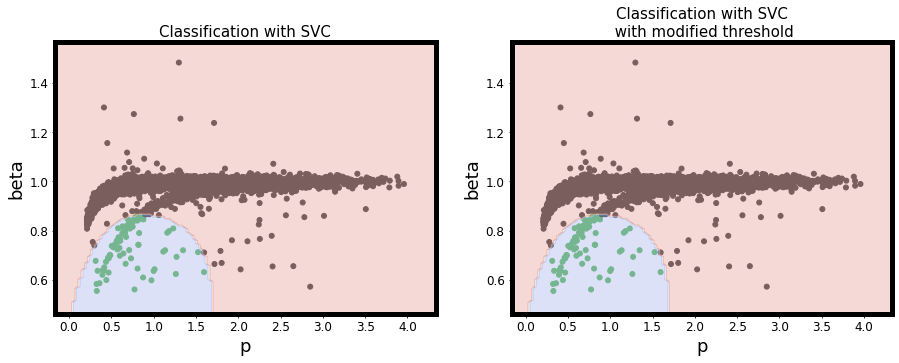

In [104]:
## Let's play with the threshold to change precision or recall of the CLF

ts=0 ## Threshold for the classification

r_predicted_Y = clf_with_thrshld(clf,ts)(X)
print('The confusion matrix is: \n {}\n'.format(confusion_matrix(Y, r_predicted_Y) ) )
print('The classification report is: \n {}\n'.format(classification_report(Y, r_predicted_Y) ) )

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121,xlabel=x_label, ylabel = y_label, title = plt_title)
ax.scatter(X[:,0],X[:,1], c=r_predicted_Y, cmap=plt.cm.Accent)
Y_grid = clf.predict( X_grid ).reshape(x1_list.shape )
ax.contourf(x1_list, x2_list, Y_grid, alpha=.2, cmap=plt.cm.coolwarm)

ax = fig.add_subplot(122,xlabel=x_label, ylabel = y_label, title = plt_title+'\n with modified threshold')
ax.scatter(X[:,0],X[:,1], c=r_predicted_Y, cmap=plt.cm.Accent)
Y_grid = clf_with_thrshld(clf,ts)( X_grid ).reshape(x1_list.shape )
ax.contourf(x1_list, x2_list, Y_grid, alpha=.2, cmap=plt.cm.coolwarm)


plt.show()

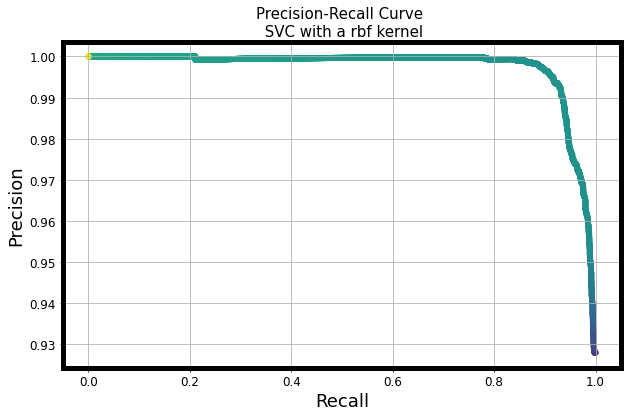

In [115]:
## Plot the precision-recall curve => Do it for SVC
from sklearn.metrics import precision_recall_curve

Y_predicted = clf.decision_function(X)

precision, recall, thresholds = precision_recall_curve(Y, Y_predicted, pos_label=1)


plt_title = 'Precision-Recall Curve \n SVC with a rbf kernel'
x_label = 'Recall'
y_label = 'Precision'

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111,xlabel=x_label, ylabel = y_label, title = plt_title)
ax.yaxis.grid()
ax.xaxis.grid()

plt.scatter(recall[1:], precision[1:], c=thresholds)
plt.show()

In [0]:
'''
Exercise: Redo this for a SGDclassifier
'''

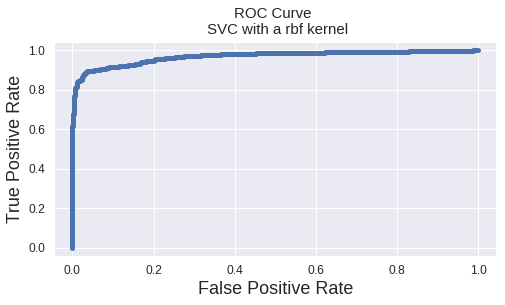

In [0]:
## AUC plot

from sklearn.metrics import roc_curve

fpr, tpr, thrsld_list = roc_curve(Y, decision_values)

plt_title = 'ROC Curve \n SVC with a rbf kernel'
x_label = 'False Positive Rate'
y_label = 'True Positive Rate'

fig = plt.figure()
ax = fig.add_subplot(111,xlabel=x_label, ylabel = y_label, title = plt_title)
plt.plot(fpr, tpr)
plt.show()

### Tuning the model

In [0]:
%%time
from scipy.stats import expon
params_dist = {'C': expon(scale=10), 'gamma':expon(scale=10)}

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
pos_label = 0
# del(pos_label)
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'precision':make_scorer(precision_score, pos_label=pos_label)
           , 'recall':make_scorer(recall_score, pos_label=pos_label), 'f1':make_scorer(f1_score, pos_label=pos_label)}

opt_clf = RandomizedSearchCV(clf, param_distributions=params_dist, cv=5, n_jobs=-1, refit='precision', scoring=scoring)
opt_clf.fit(X_train,Y_train)

CPU times: user 372 ms, sys: 15.8 ms, total: 387 ms
Wall time: 15.6 s


In [0]:
result = pd.DataFrame(opt_clf.cv_results_)
result

,mean_fit_time,mean_score_time,mean_test_AUC,mean_test_Accuracy,mean_test_f1,mean_test_precision,mean_test_recall,mean_train_AUC,mean_train_Accuracy,mean_train_f1,...,std_test_AUC,std_test_Accuracy,std_test_f1,std_test_precision,std_test_recall,std_train_AUC,std_train_Accuracy,std_train_f1,std_train_precision,std_train_recall
0,0.097239,0.067071,0.968981,0.946708,0.512904,0.780771,0.387883,0.974048,0.948360,0.529748,...,0.009426,0.003296,0.029083,0.095619,0.042421,0.001268,0.003182,0.038782,0.029312,0.037191
1,0.140488,0.109269,0.968758,0.935917,0.293961,0.759781,0.184861,0.970855,0.936303,0.295410,...,0.008163,0.003651,0.046586,0.129433,0.036370,0.001418,0.001152,0.023805,0.016051,0.017863
2,0.126543,0.086434,0.974062,0.964325,0.731588,0.816267,0.669693,0.982937,0.969060,0.766017,...,0.005783,0.006045,0.042453,0.083644,0.058597,0.001342,0.001273,0.009802,0.011303,0.010442
3,0.137045,0.102568,0.970852,0.953094,0.592101,0.812883,0.472727,0.975955,0.953975,0.597333,...,0.008565,0.004258,0.048072,0.082193,0.063122,0.001026,0.001382,0.010403,0.022549,0.007946
4,0.149833,0.118066,0.967999,0.936358,0.288518,0.801655,0.178799,0.970569,0.936578,0.288638,...,0.007776,0.003719,0.046686,0.149466,0.035082,0.001354,0.001676,0.025527,0.035012,0.017506
5,0.127338,0.092023,0.971010,0.961242,0.690769,0.830580,0.596965,0.977796,0.963114,0.706711,...,0.005943,0.005533,0.042422,0.085809,0.054708,0.001936,0.002282,0.020496,0.018456,0.024966
6,0.142704,0.105231,0.969283,0.951773,0.576056,0.809106,0.454545,0.974745,0.951608,0.570924,...,0.008899,0.004733,0.047833,0.093656,0.062831,0.001102,0.002075,0.020018,0.024441,0.017767
7,0.147419,0.109853,0.968643,0.939000,0.395708,0.731578,0.281846,0.972866,0.941973,0.428034,...,0.009722,0.004915,0.074949,0.127210,0.078217,0.001368,0.002610,0.045563,0.015719,0.042761
8,0.148303,0.114482,0.969809,0.937018,0.335972,0.745868,0.221227,0.972480,0.937734,0.335013,...,0.008843,0.004086,0.048855,0.132890,0.043499,0.001384,0.000406,0.009243,0.011510,0.007946
9,0.136502,0.105024,0.968960,0.951553,0.567783,0.819299,0.439394,0.975355,0.953535,0.584893,...,0.009968,0.003322,0.030134,0.085476,0.041765,0.001545,0.001714,0.017917,0.023178,0.018863


In [0]:
opt_predicted_Y = opt_clf.predict(X)
print('The confusion matrix is: \n {}'.format(confusion_matrix(Y, opt_predicted_Y) ) )
print('The classification report is: \n {}'.format(classification_report(Y, opt_predicted_Y) ) )

The confusion matrix is: 
 [[ 276  165]
 [  50 5564]]
The classification report is: 
               precision    recall  f1-score   support

           0       0.85      0.63      0.72       441
           1       0.97      0.99      0.98      5614

   micro avg       0.96      0.96      0.96      6055
   macro avg       0.91      0.81      0.85      6055
weighted avg       0.96      0.96      0.96      6055



## Multi-Class evalution

In [0]:
'''
For the data, we need to use the mini_data instead of bmd
'''

## Only keep the part of the data with one of the two target classes. 
bmd = mini_data[ (mini_data['target']==ind_1) | (mini_data['target']==ind_2) ].copy()


m_X =  mini_data.drop('target', axis=1).values
m_Y =  mini_data['target'].values

m_X_train, m_X_test, m_Y_train, m_Y_test = train_test_split(m_X  , m_Y, random_state = 0 )

The confusion matrix is: 
     0     1    2  3
0  42    76    8  0
1   9  1364   14  0
2   1    12  969  0
3   0     3    0  2

The classification report is: 
               precision    recall  f1-score   support

           0       0.81      0.33      0.47       126
           1       0.94      0.98      0.96      1387
           2       0.98      0.99      0.98       982
           3       1.00      0.40      0.57         5

    accuracy                           0.95      2500
   macro avg       0.93      0.68      0.75      2500
weighted avg       0.95      0.95      0.94      2500
 



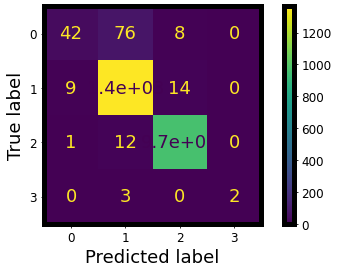

In [130]:
g = 10
m_clf = SVC(gamma=g)
m_clf.fit(m_X_train, m_Y_train)

m_predicted_Y = m_clf.predict(m_X_test)


print('The confusion matrix is: \n {}\n'.format(pd.DataFrame(confusion_matrix(m_Y_test, m_predicted_Y)) ) )
plot_confusion_matrix(m_clf, m_X_test, m_Y_test, labels = [0,1,2,3])
print('The classification report is: \n {} \n'.format(classification_report(m_Y_test, m_predicted_Y) ) )

In [125]:
Y_predicted = m_clf.decision_function(m_X).T
print(Y_predicted.shape )

(4, 10000)


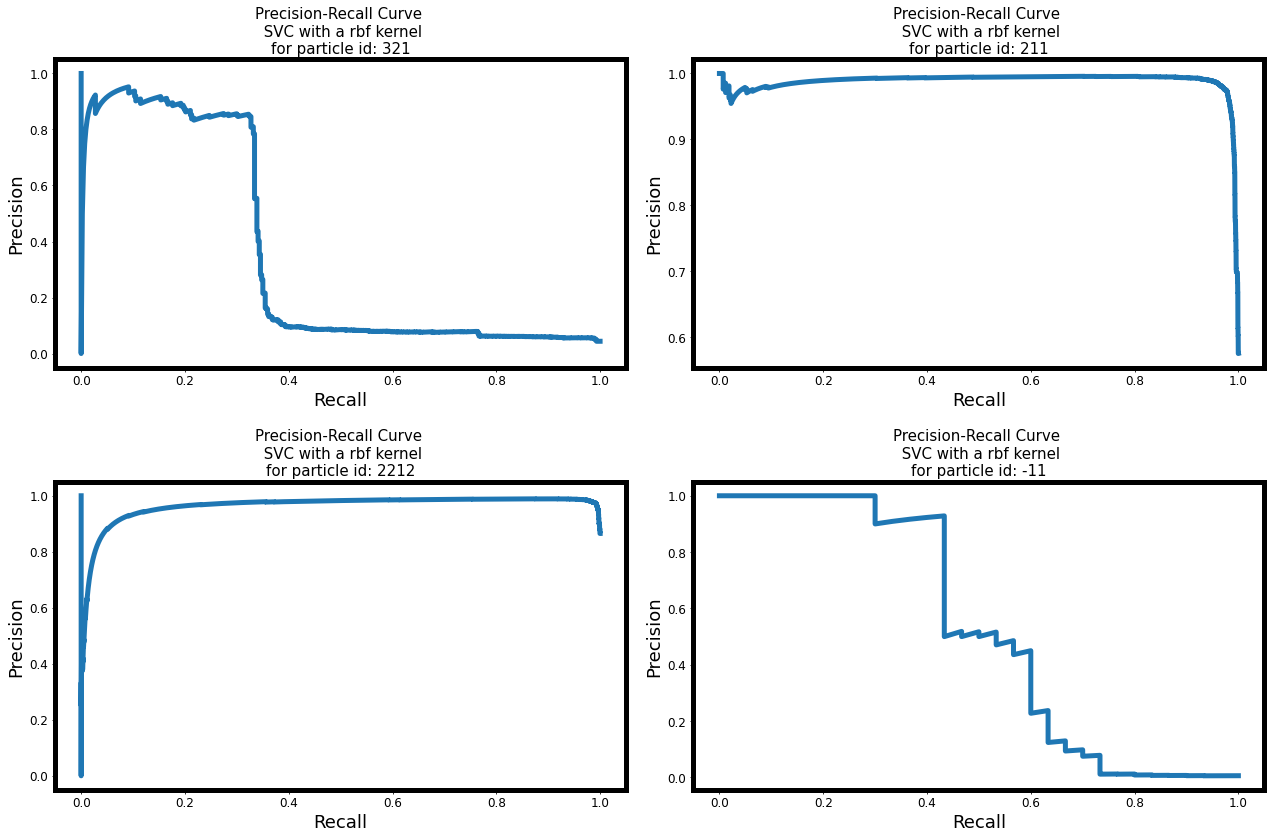

In [132]:
plt_title = 'Precision-Recall Curve \n SVC with a rbf kernel\n'
x_label = 'Recall'
y_label = 'Precision'

fig = plt.figure(figsize=(18,12))

for pos_label in [0,1,2,3]:
  precision, recall, thresholds = precision_recall_curve(m_Y, Y_predicted[pos_label], pos_label=pos_label )
  ax = fig.add_subplot(2,2,pos_label+1,xlabel=x_label, ylabel = y_label, title = plt_title+'for particle id: {}'.format(targets[pos_label])  )
  plt.plot(recall, precision)
  

plt.tight_layout()  
plt.show()

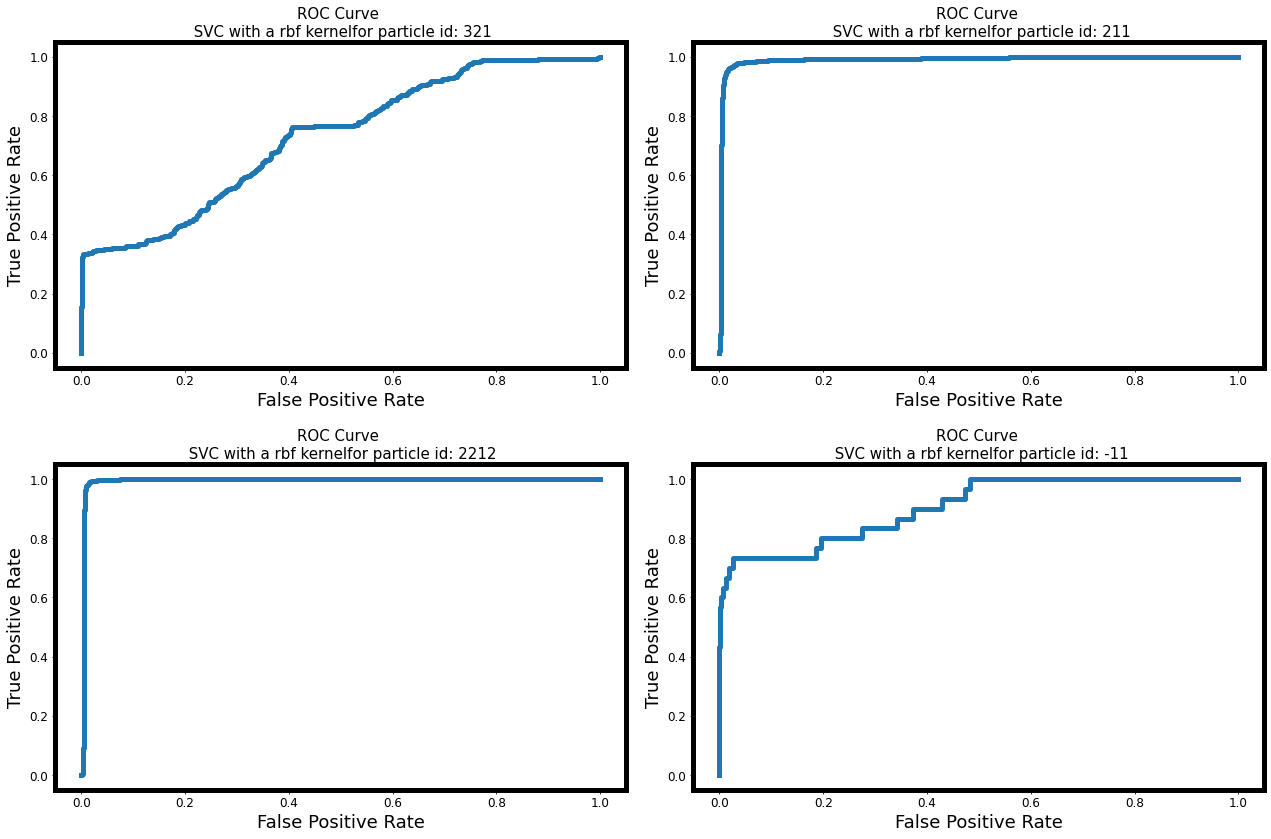

In [134]:
plt_title = 'ROC Curve \n SVC with a rbf kernel'
x_label = 'False Positive Rate'
y_label = 'True Positive Rate'

from sklearn.metrics import roc_curve

fig = plt.figure(figsize=(18,12))

for pos_label in [0,1,2,3]:
  fpr, tpr, thrsld_list = roc_curve(m_Y, Y_predicted[pos_label], pos_label=pos_label )
  ax = fig.add_subplot(2,2,pos_label+1,xlabel=x_label, ylabel = y_label, title = plt_title+'for particle id: {}'.format(targets[pos_label])  )
  ax.plot(fpr, tpr)
  

plt.tight_layout()  
plt.show()